In [ ]:
!rm -r train

In [ ]:
!wget -O datasets.zip https://storage.yandexcloud.net/datasouls-ods/materials/46b7bb85/datasets.zip > /dev/null

--2020-11-09 23:47:58--  https://storage.yandexcloud.net/datasouls-ods/materials/46b7bb85/datasets.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640106308 (610M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>] 610.45M  20.0MB/s    in 33s     

2020-11-09 23:48:32 (18.6 MB/s) - ‘datasets.zip’ saved [640106308/640106308]



In [ ]:
!unzip -qq datasets.zip

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm_notebook
import time

from sklearn.model_selection import KFold, train_test_split
import editdistance

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Dense, LSTM, Lambda, TimeDistributed, Reshape, Bidirectional, Dropout, Attention, GRU, Input, Activation,
                                     Conv2D, AveragePooling2D, Add, Concatenate, MaxPooling2D, BatchNormalization, Multiply, Permute)
# from tensorflow.keras.activations import LeakyRelu
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
import albumentations as A
import cv2
from collections import Counter
import gc

from tensorflow.keras.backend import permute_dimensions

RANDOM_STATE = 0
H = 128
W = 1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 0.Examples


упават
(157, 283, 3)


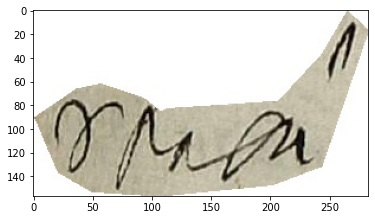

In [ ]:

img = plt.imread('train/images/'+os.listdir('train/images')[10])
plt.imshow(img)
with open('train/words/'+os.listdir('train/images')[10].split('.')[0]+'.txt','r',encoding='utf-8') as f:
    print(f.read())
    print(img.shape)

писмом свободен]
(174, 712, 3)


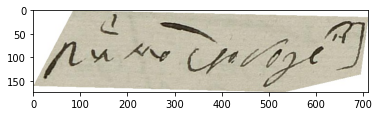

In [ ]:
img = plt.imread('train/images/'+os.listdir('train/images')[15])
plt.imshow(img)
with open('train/words/'+os.listdir('train/images')[15].split('.')[0]+'.txt','r',encoding='utf-8') as f:
    print(f.read())
    print(img.shape)

+
(102, 146, 3)


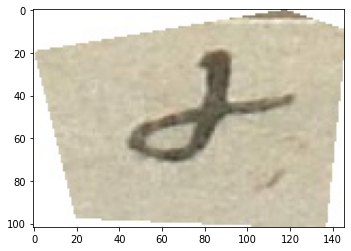

In [ ]:
img = plt.imread('train/images/'+os.listdir('train/images')[100])
plt.imshow(img)
with open('train/words/'+os.listdir('train/images')[100].split('.')[0]+'.txt','r',encoding='utf-8') as f:
    print(f.read())
    print(img.shape)

# 1.Main Classes and functions

In [ ]:
class ImageTextGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, lines, names, image_dir, alphabet, validation=False, shuffle=True, augment=0, batch_size=32, W=128, H=1024, augmenter=None):
        # lines - labels
        # names - filenames
        # image_dir - directory with images
        # alphabet - all characters
        # validation - if this generator for validation or not
        # shuffle - shuffle data or not
        # augment - real/syntetic ratio. If zero then no augmentation
        # batch_size - batch_size
        # W - image y
        # H - image x

        'Initialization'
        assert augment >= 0
        assert augment <= 1
        self.batch_size = batch_size
        self.lines = lines
        self.names = names
        self.image_dir = image_dir
        self.alphabet = alphabet
        self.W = W
        self.H = H
        self.shuffle = shuffle
        self.validation = validation
        self.augment = augment
        self.size = len(self.lines)
        self.real_len = len(self.lines)
        if augmenter is None:
            self.augmenter = A.Compose([
                A.Resize(int(self.W*1.05), int(self.H*1.05)),
                A.RandomCrop(self.W, self.H),
                A.Rotate(limit=(-15, 15), border_mode=cv2.BORDER_CONSTANT)
            ])
        self.size = self.size//batch_size
        np.random.seed(0)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if index == 0:
            self.on_epoch_end()
        indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]

        # Find list of IDs
        batch_names = [self.names[k] for k in indexes]
        batch_lines = [self.lines[k] for k in indexes]

        # Generate data
        X = self.__data_generation(batch_names, batch_lines)

        y = np.zeros(len(X[0]))
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.lines))
        
        if self.shuffle and not self.validation:
            np.random.shuffle(self.indexes)


    def process_image(self, img):
        if not self.validation:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            img = self.augmenter(image=img)['image']
            img = img/255.0
            img = img**(random.random()*0.7 + 0.6)
        else:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            img = img/255.0
        return img

    def text2labels(self, text):
        return list(map(lambda x: self.alphabet.index(x) , text))

    def __data_generation(self, batch_names, batch_lines):
        data_images = []
        data_labels = []
        data_input_length = []
        data_label_length = []
        for line, name in zip(batch_lines, batch_names):
            img = cv2.imread(self.image_dir+'/'+name, cv2.IMREAD_GRAYSCALE)
            try:
                label = self.text2labels(line)
            except:
                print('bad_label')
                continue
            if len(line) == 0:
                continue
            
            img = self.process_image(img)
            data_images.append(img)
            data_labels.append(label)
            data_input_length.append(255)
            data_label_length.append(len(line))
        data_labels = pad_sequences(np.array(data_labels), 
                            maxlen=71, 
                            padding='post',
                            value=len(self.alphabet))
            
        return np.asarray(data_images), data_labels, np.asarray(data_input_length), np.asarray(data_label_length)

    def flow(self):
        batch_size = self.batch_size
        i = 0
        max_i = self.__len__()
        while True:
            if i == max_i:
                i = 0
            items = self.__getitem__(i)
            i += 1
            yield items


class CWERCheckpoint(Callback):
    def __init__(self, original_texts, alphabet, val_gen, act_model, patience=10, lr_patience=10, factor=0.7, min_lr=1e-5):
        self.original_texts = original_texts
        self.val_gen = val_gen
        self.alphabet = alphabet
        self.min_cer = 10000
        self.min_wer = 10000
        self.max_acc = 0
        self.patience = patience
        self.act_model = act_model
        self.best_weights = None
        self.lr_patience = lr_patience
        self.factor = factor
        self.min_lr = min_lr
        

    def on_train_begin(self, logs=None):
        self.best_cer = 10000
        self.epoch_end = 0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.act_model.set_weights(self.model.get_weights())
        prediction = self.act_model.predict(self.val_gen.flow(), steps=self.val_gen.__len__())
        decoded = K.ctc_decode(prediction, 
                            input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                            greedy=True)[0][0]
        out = K.get_value(decoded)

        # --- EVALUATION ---
        numCharErr = 0
        numCharTotal = 0
        numStringOK = 0
        numStringTotal = 0

        word_eds, word_true_lens = [], []

        for i in range(len(out)):
            pred = ''
            for p in out[i]:
                if int(p) != -1:
                    pred+=self.alphabet[int(p)]
            true = self.original_texts[i]
            
            numStringOK += 1 if true == pred else 0
            numStringTotal += 1
            dist = editdistance.eval(pred, true)
            numCharErr += dist
            numCharTotal += len(true)
            
            pred_words = pred.split()
            true_words = true.split()
            word_eds.append(editdistance.eval(pred_words, true_words))
            word_true_lens.append(len(true_words))
            
        charErrorRate = numCharErr / numCharTotal
        wordErrorRate = sum(word_eds) / sum(word_true_lens) 
        stringAccuracy = numStringOK / numStringTotal
        print('CER: %f%%. WER: %f%%. SACC: %f%%.' % \
        (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))
        

        if self.best_cer > charErrorRate*100.0:
            self.best_cer = charErrorRate*100
            self.wait = 0
            self.wait_lr = 0
            self.best_weights = self.model.get_weights()
            self.model.save_weights('best_weights_1.hdf5')
        else:
            self.wait += 1
            self.wait_lr += 1
            if self.wait >= self.patience and self.patience != 0:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

            if self.wait_lr >= self.lr_patience and self.lr_patience != 0 and self.model.optimizer.learning_rate != self.min_lr:
                print('Learing rate was changed:', self.model.optimizer.learning_rate, end=' -> ')
                self.model.optimizer.learning_rate = self.factor*self.model.optimizer.learning_rate
                if self.model.optimizer.learning_rate < self.min_lr:
                    self.model.optimizer.learning_rate = self.min_lr
                print(self.model.optimizer.learning_rate)
                self.wait_lr = 0

        
        del (charErrorRate, wordErrorRate,
            stringAccuracy, prediction, decoded, out, word_eds, word_true_lens)
        gc.collect()
    
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

def binarize_image(image, black_on_white=False):
    return (image < 120)*255


def blur_images(image, blur_weight=1):
    return cv2.medianBlur(image, blur_weight)

def dilate_image(image, kernel = np.ones((1, 1), np.uint8), iterations=1):
    img_dilated = cv2.dilate(image, kernel, iterations=iterations)
    return img_dilated
        

def process_image(img, W=128, H=1024):
    w, h = img.shape
    
    if w == W and h == H:
        return img

    if w > h*1.1:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    w, h = img.shape
    new_w = W
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
            
    zeros = np.full((W, H), 255)
    if h < H:
        zeros[:, :h] = img
        img = zeros.copy()
                    
    elif h > H:
        dim = (H, W)
        img = cv2.resize(img, dim)
    
    img = binarize_image(img).astype(np.uint8)
    #img = blur_images(img, 1)
    img = (dilate_image(img, kernel=np.ones((2, 2), np.uint8)) == 0)*255
    return img

# 2.Data processing

In [ ]:
def get_an_alphabet(dir, threshold):
    # dir - directory with labels
    # threshold - minimal count of letter
    files = os.listdir(dir)
    common_text = ''
    for file_name in files:
        with open(dir+'/'+file_name, 'r', encoding='utf-8') as f:
            common_text += f.read()
    alphabet, cntr = list(set([el for el in common_text])), Counter([el for el in common_text])

    cntr = pd.DataFrame(dict(cntr).items())
    alphabet = cntr[cntr[1] >= threshold][0].values.tolist()
    alphabet.remove('і')
    bad_alphabet = cntr[cntr[1] < threshold][0].values.tolist()+['і']
    print('Мощность алфавита:', len(alphabet))
    print(alphabet)
    return alphabet, bad_alphabet

In [ ]:
alphabet, bad_alphabet = get_an_alphabet('train/words', 11)

Мощность алфавита: 54
['л', 'и', 'к', 'о', 'й', ' ', 'у', 'р', 'н', 'м', 'г', 'т', 'ч', 'а', 'ц', 'п', 'в', 'ы', 'i', 'с', 'д', 'е', 'ж', 'б', 'я', 'х', 'ѣ', 'ъ', 'ш', 'з', 'ю', 'ф', '[', ']', 'ь', '1', '5', '0', '+', 'щ', '7', '2', '6', '3', 'p', 's', 'f', '4', 't', 'e', 'r', '8', 'э', '9']


In [ ]:
def process_texts(image_dir, trans_dir, alphabet, bad_alphabet, mode=0):
    # image_dir - images directory
    # trans_dir - transcriptions directory
    # modes - text process mode, where 0 for deleting lines with bad letters
    #                                  1 for deleting bad letters in the string
    max_len = 0
    lines = []
    names = []
    c = 0
    c_del = 0
    
    all_files = os.listdir(trans_dir)
    for filename in os.listdir(image_dir):
        if filename[:-3]+'txt' in all_files:
            name, ext = os.path.splitext(filename)
            txt_filepath = os.path.join(trans_dir, name + '.txt')
            with open(txt_filepath, 'r') as file:
                data = file.read()
                if len(data) == 0:
                    c += 1
                    continue
                if len(set(data).intersection(bad_alphabet))>0:
                    if mode:
                        data = ''.join([el for el in data if not el in bad_alphabet])
                    else:
                        c_del += 1
                        continue

                lines.append(data)
                names.append(filename)
                max_len = len(data) if len(data) > max_len else max_len
    print('Максимальная длина строки:', max_len)
    print('Количество нулевых строк:', c)
    print('Удалено строк:', c_del)
    return names, lines

In [ ]:
names, lines = process_texts('train/images', 'train/words', alphabet, bad_alphabet, 0)

Максимальная длина строки: 71
Количество нулевых строк: 0
Удалено строк: 64


In [ ]:
for name in tqdm_notebook(names):
    img = cv2.imread('train/images/'+name, cv2.IMREAD_GRAYSCALE)
    img = process_image(img, H, W)
    cv2.imwrite('train/images/'+name, img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [ ]:
# Create validation set
names_val = []
lines_val = []
names_train = []
lines_train = []
for name, line in zip(names, lines):
    if name[-5] == '9':
        names_val.append(name)
        lines_val.append(line)
    else:
        names_train.append(name)
        lines_train.append(line)
print('Train and val shapes:', len(names_train), len(names_val))

Train and val shapes: 5698 434


In [ ]:
train_gen = ImageTextGenerator(lines_train, names_train, 'train/images', alphabet, validation=False, shuffle=True, augment=1, batch_size=32, W=H, H=W)
val_gen = ImageTextGenerator(lines_val, names_val, 'train/images', alphabet, validation=True, shuffle=False, augment=0, batch_size=32, W=H, H=W)

# 3.Model

In [ ]:
from keras.layers import Flatten, Concatenate, Average

In [ ]:
# RESNET EXTRACTOR
inputs = Input(shape=(H, W, 1))

conv_1 = Conv2D(64, (3, 3), (1, 1), padding='same', activation='relu')(inputs)
bn_1 = BatchNormalization()(conv_1)
relu_1 = Activation('relu')(bn_1)
pool_1 = AveragePooling2D(pool_size=(4, 2), strides=(2, 2))(relu_1)

conv_2 = Conv2D(64, (3, 3), (1, 1), padding='same', activation='relu')(pool_1)
bn_2 = BatchNormalization()(conv_2)
relu_2 = Activation('relu')(bn_2)
conv_2_1 = Conv2D(64, (3, 3), (1, 1), padding='same', activation='relu')(relu_2)
bn_2_1 = BatchNormalization()(conv_2_1)
add_2 = Add()([bn_2_1, pool_1])

conv_3 = Conv2D(128, (3, 3), (1, 1), padding='same', activation='relu')(add_2)
bn_3 = BatchNormalization()(conv_3)
relu_3 = Activation('relu')(bn_3)
conv_3_1 = Conv2D(128, (3, 3), (1, 1), padding='same', activation='relu')(relu_3)
bn_3_1 = BatchNormalization()(conv_3_1)
conv_3r = Conv2D(128, (3, 3), (1, 1), padding='same', activation='relu')(add_2)
bn_3r = BatchNormalization()(conv_3r)
add_3 = Add()([bn_3_1, bn_3r])
pool_3 = MaxPooling2D(pool_size=(4, 2), strides=(2, 2))(add_3)

conv_4 = Conv2D(256, (3, 3), (1, 1), padding='same', activation='relu')(pool_3)
bn_4 = BatchNormalization()(conv_4)
relu_4 = Activation('relu')(bn_4)
conv_4_1 = Conv2D(256, (3, 3), (1, 1), padding='same', activation='relu')(relu_4)
bn_4_1 = BatchNormalization()(conv_4_1)
conv_4r = Conv2D(256, (3, 3), (1, 1), padding='same', activation='relu')(pool_3)
bn_4r = BatchNormalization()(conv_4r)
add_4 = Add()([bn_4_1, bn_4r])
pool_4 = MaxPooling2D(pool_size=(4, 1), padding='same')(add_4)

conv_5 = Conv2D(512, (3, 3), (1, 1), padding='same', activation='relu')(pool_4)
bn_5 = BatchNormalization()(conv_5)
relu_5 = Activation('relu')(bn_5)
conv_5_1 = Conv2D(512, (3, 3), (1, 1), padding='same', activation='relu')(relu_5)
bn_5_1 = BatchNormalization()(conv_5_1)
conv_5r = Conv2D(512, (3, 3), (1, 1), padding='same', activation='relu')(pool_4)
bn_5r = BatchNormalization()(conv_5r)
add_5 = Add()([bn_5_1, bn_5r])
pool_5 = MaxPooling2D(pool_size=(4, 1), padding='same')(add_5)
conv_5_2 = Conv2D(512, (2, 2), (1, 1), activation='relu')(pool_5)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_5_2)

blstm_1 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.1))(squeezed)
blstm_2 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.1))(blstm_1)
blstm_3 = Bidirectional(GRU(256, return_sequences=True, dropout = 0.1))(blstm_2)

outputs = Dense(len(alphabet)+1, activation = 'softmax')(blstm_3)
act_model = Model(inputs=inputs, outputs=outputs)
    
the_labels = Input(name='the_labels', shape=[71], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=[loss_out])

In [ ]:
texts = []
for name in val_gen.names:
    with open('train/words/'+name[:-3]+'txt', 'r', encoding='utf-8') as f:
        texts.append(f.read())

In [ ]:
epochs = 300

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', metrics=['accuracy'])

cwer = CWERCheckpoint(texts, alphabet, val_gen, act_model, patience=0)
callbacks_list = [cwer]

history = model.fit_generator(train_gen.flow(), epochs=epochs,
                             validation_data=val_gen.flow(), verbose=1, callbacks=callbacks_list, 
                              steps_per_epoch=train_gen.__len__(), validation_steps=val_gen.__len__())


Epoch 1/300
178/178 [==============================] - 142s 800ms/step - loss: 102.5400 - accuracy: 0.0000e+00 - val_loss: 94.1702 - val_accuracy: 0.0000e+00
Epoch 2/300
178/178 [==============================] - 137s 770ms/step - loss: 88.6727 - accuracy: 0.0000e+00 - val_loss: 146.8301 - val_accuracy: 0.0000e+00
Epoch 3/300
178/178 [==============================] - 137s 770ms/step - loss: 83.6820 - accuracy: 0.0000e+00 - val_loss: 94.2056 - val_accuracy: 0.0000e+00
Epoch 4/300
178/178 [==============================] - 137s 771ms/step - loss: 53.7898 - accuracy: 0.0000e+00 - val_loss: 93.3967 - val_accuracy: 0.0000e+00
Epoch 5/300
178/178 [==============================] - 137s 772ms/step - loss: 30.9601 - accuracy: 1.7556e-04 - val_loss: 37.7035 - val_accuracy: 0.0000e+00
Epoch 6/300
178/178 [==============================] - 137s 770ms/step - loss: 25.5938 - accuracy: 0.0030 - val_loss: 85.0555 - val_accuracy: 0.0000e+00
Epoch 7/300
178/178 [==============================] - 137s 

In [ ]:
import time
start = time.time()
act_model.load_weights('best_weights_1.hdf5')
prediction = act_model.predict(val_gen.flow(), steps=val_gen.__len__())

decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)
end = time.time()
print(end-start)

3.87331485748291


In [ ]:
numCharErr = 0
numCharTotal = 0
numStringOK = 0
numStringTotal = 0

word_eds, word_true_lens = [], []

print('Ground truth -> Recognized')	
for i in range(len(out)):
    pred = ''
    for p in out[i]:
        if int(p) != -1:
            pred+=alphabet[int(p)]
    true = texts[i]
    
    numStringOK += 1 if true == pred else 0
    numStringTotal += 1
    dist = editdistance.eval(pred, true)
    numCharErr += dist
    numCharTotal += len(true)
    
    pred_words = pred.split()
    true_words = true.split()
    word_eds.append(editdistance.eval(pred_words, true_words))
    word_true_lens.append(len(true_words))
    
    print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + true + '"', '->', '"' + pred + '"')

charErrorRate = numCharErr / numCharTotal
wordErrorRate = sum(word_eds) / sum(word_true_lens) 
stringAccuracy = numStringOK / numStringTotal
print('Character error rate: %f%%. Word error rate: %f%%. String accuracy: %f%%.' % \
      (charErrorRate*100.0,wordErrorRate*100.0, stringAccuracy*100.0))

Ground truth -> Recognized
[ERR:5] "з другой но сие не точию от а" -> "з другой но се не почию ба"
[OK] "годарно принели також" -> "годарно принели також"
[ERR:3] "застат поклон отдай теткѣ от" -> "застат поклон отдайтеткѣ б"
[ERR:1] "ть iмѣли что шведы" -> "то iмѣли что шведы"
[ERR:4] "дня будем якор бросат у александровой крѣ" -> "дня будем якорбросат у алетандвовой крѣ"
[ERR:3] "ник от своево двора от первово министра" -> "ник от своево двора от первовоми нис тра"
[OK] "нѣт а iтит заказывают а что вы" -> "нѣт а iтит заказывают а что вы"
[ERR:2] "рой хотя i боронил оныя прекрѣпъкия пасажи" -> "рой хотя i боронил оныя преквѣпъкия пасаже"
[OK] "ево склонность к тому то" -> "ево склонность к тому то"
[ERR:1] "ба одного ничего не iмѣютъ что нас зе" -> "ба одного ничего не iмѣютъ что насзе"
[OK] "волхова на вол" -> "волхова на вол"
[ERR:25] "тират " -> "тират чего всегда i от в в неот"
[ERR:2] "[протчее полагаетца на волю кав i воiн" -> "[протчее полагаетца наволю ка в i воiн"
[OK] "прежд